In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize

In [2]:
#import data for  stocks that I personally have held over the past year
apple = yf.download("AAPL",start='2023-04-06', end = datetime.now(),auto_adjust=True)
ibm = yf.download("IBM",start='2023-04-06', end = datetime.now(),auto_adjust=True)
arm = yf.download("ARM",start='2023-04-06', end = datetime.now(),auto_adjust=True)
rollsroyce = yf.download("RR.L",start='2023-04-06', end = datetime.now(),auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
#concatenate the daily adj close price of each stock into a single dataframe
myStocks = pd.concat([apple['Close'],ibm['Close'],arm['Close'],rollsroyce['Close']],axis=1)

#calculate logarithmic returns and remove rows with null values (EG Holidays)
logReturns = np.log(myStocks/myStocks.shift(1)).dropna()

#store covariance matrix of log returns for each stock
logReturnsCov=logReturns.cov()

In [4]:
#store number of stocks
n = len(logReturns.columns)

In [5]:
#generate an array of n random numbers, with a sum of one

def generateWeights(n):
    weights = np.random.random(n)
    weights = weights/np.sum(weights)

    return weights

In [6]:
#calculate annualised logarithmic returns, given some weighting

def calculateReturns(logReturns,weights):
    annualisedLogRets = np.sum(logReturns.mean()*weights)*252
    return annualisedLogRets

In [7]:
#calculate volatility (standard deviation) using two matrix multiplications

def calculateVolatility(logReturns,weights):
    volatility = weights.T @ (logReturns.cov()*252 @ weights)
    return np.sqrt(volatility)

In [8]:
#run Monte Carlo Simulation

weightsList = []
returnsList = []
volatilityList = []

for sim in range(6000):
    weights = generateWeights(n)
    weightsList.append(weights)
    returnsList.append(calculateReturns(logReturns,weights))
    volatilityList.append(calculateVolatility(logReturns,weights))


sharpeRatios = (np.array(returnsList) - 0.041)/np.array(volatilityList)

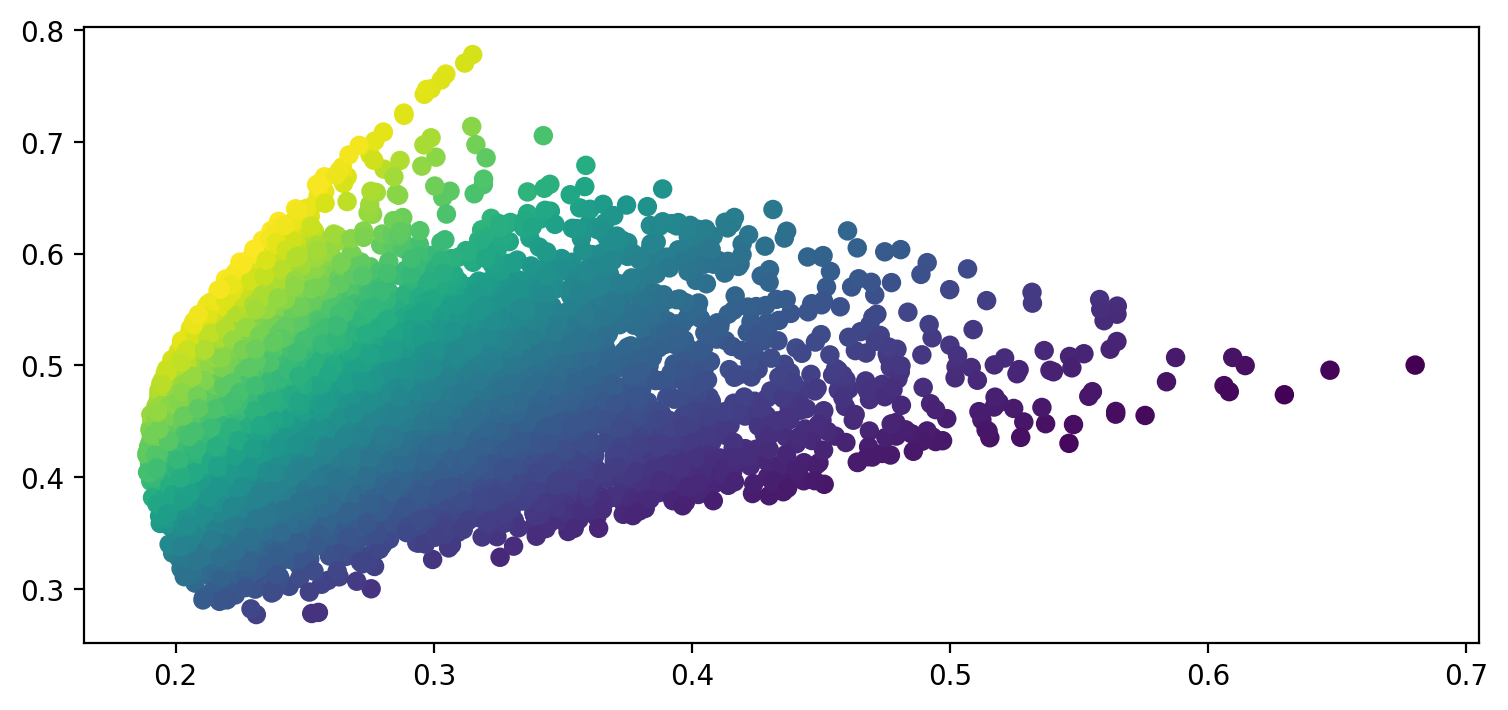

In [9]:
#plot Monte Carlo Simulation
plt.figure(dpi=200,figsize=(9,4))
plt.scatter(volatilityList,returnsList,c=sharpeRatios)

In [10]:
def functionToMinimize(weights):
    return -1 * ((calculateReturns(logReturns,weights) - 0.041)/calculateVolatility(logReturnsCov,weights))

bounds = tuple((0,1)  for x in range(n))
startguess = np.array([1/n for x in range(n)])
sum_constraint = ({'type':'eq','fun':lambda weights:np.sum(weights)-1})

y=minimize(fun=functionToMinimize,x0=startguess,bounds=bounds,constraints=sum_constraint)
y


     message: Positive directional derivative for linesearch
     success: False
      status: 8
         fun: -898.7623972067446
           x: [ 2.997e-01  3.919e-01  1.599e-05  3.087e-01]
         nit: 21
         jac: [-2.580e+01 -8.924e+01  2.563e+04 -1.584e+02]
        nfev: 102
        njev: 17
 multipliers: [-8.963e+01]

In [14]:
expectedReturnsRange = np.linspace(0.3,0.8,100)

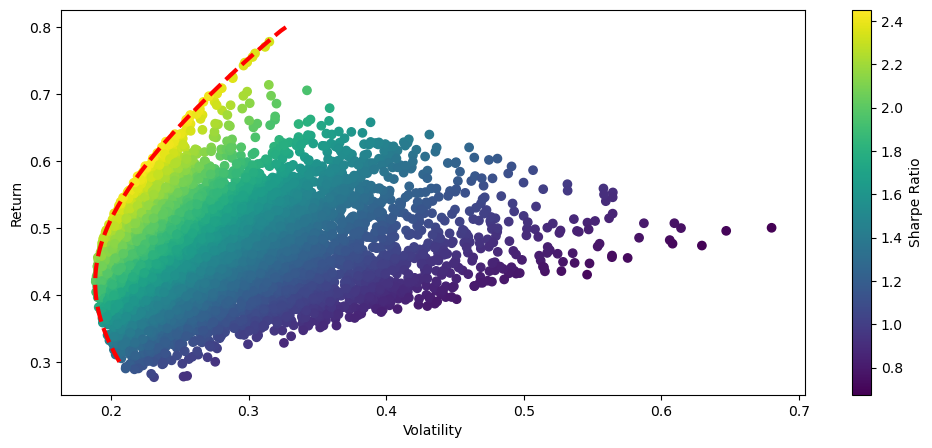

In [20]:

frontierVol = []

def volatilityMinimizerFunction(weights):
    annualized_cov = np.dot(logReturnsCov*252,weights)
    vol = np.dot(weights.transpose(),annualized_cov)
    return np.sqrt(vol)

vol = np.sqrt(np.dot(weights.T, np.dot(logReturnsCov * 252, weights)))

for possibleReturn in expectedReturnsRange:
    frontierConstraint = ({'type':'eq','fun':lambda weights:calculateReturns(logReturns,weights) - possibleReturn},{'type':'eq','fun':lambda weights:np.sum(weights)-1})
    result = minimize(fun=volatilityMinimizerFunction,x0=startguess,bounds=bounds,constraints=frontierConstraint)
    frontierVol.append(result['fun'])



plt.figure(figsize=(12,5))
plt.scatter(volatilityList,returnsList,c=sharpeRatios)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add frontier line
plt.plot(frontierVol,expectedReturnsRange, 'r--',lw=3)

